# Refatoração do XGBoost

### 1: Importações e configurações iniciais

In [ ]:
# Configurações iniciais
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Adicionar o diretório raiz ao path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

# Importações de terceiros
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importações locais
from src.utils import (
    load_data, preprocess_data, create_preprocessor,
    analisar_dados, analisar_valores_ausentes,
    plot_distribuicao_numerica, plot_correlacao,
    evaluate_model, plot_residuals
)

# Configurações de exibição
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_style('whitegrid')
%matplotlib inline

print("Configuração inicial concluída!")

Configuração inicial concluída!


### 2: Carregamento dos Dados

In [4]:
def carregar_dados(caminho_dados='../../data/raw'):
    """Carrega e retorna os dados de treino e teste."""
    print("Carregando os dados...")
    try:
        train_df, test_df = load_data(caminho_dados)
        print(f"Dados de treino carregados: {train_df.shape}")
        print(f"Dados de teste carregados: {test_df.shape}")
        return train_df, test_df
    except Exception as e:
        print(f"Erro ao carregar os dados: {e}")
        raise

# Carregar dados
train_df, test_df = carregar_dados()

Carregando os dados...
Dados de treino carregados: (1460, 81)
Dados de teste carregados: (1459, 80)


### 3: Análise Exploratória de Dados


=== Análise Exploratória de Dados ===

Visualizando as primeiras linhas do conjunto de treino:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



Estatísticas descritivas:


,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0



Análise de valores ausentes:

ANÁLISE DE VALORES AUSENTES

Visão Geral:
- Total de linhas: 1460
- Total de colunas: 81
- Colunas com valores ausentes: 19 (23.5% do total)

Detalhes dos Valores Ausentes:


,Total,Porcentagem
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageQual,81,5.547945
GarageFinish,81,5.547945
GarageType,81,5.547945



Análise por Tipo de Dado:


int64         0
float64     348
object     7481
dtype: int64


Recomendações:

1. Considerar remover as seguintes colunas (mais de 30.0% de valores ausentes):
   - PoolQC (99.5% ausentes)
   - MiscFeature (96.3% ausentes)
   - Alley (93.8% ausentes)
   - Fence (80.8% ausentes)
   - MasVnrType (59.7% ausentes)
   - FireplaceQu (47.3% ausentes)

2. Para as demais colunas, considere:
   - Para colunas numéricas: preencher com mediana ou média
   - Para colunas categóricas: criar categoria 'Desconhecido' ou usar a moda


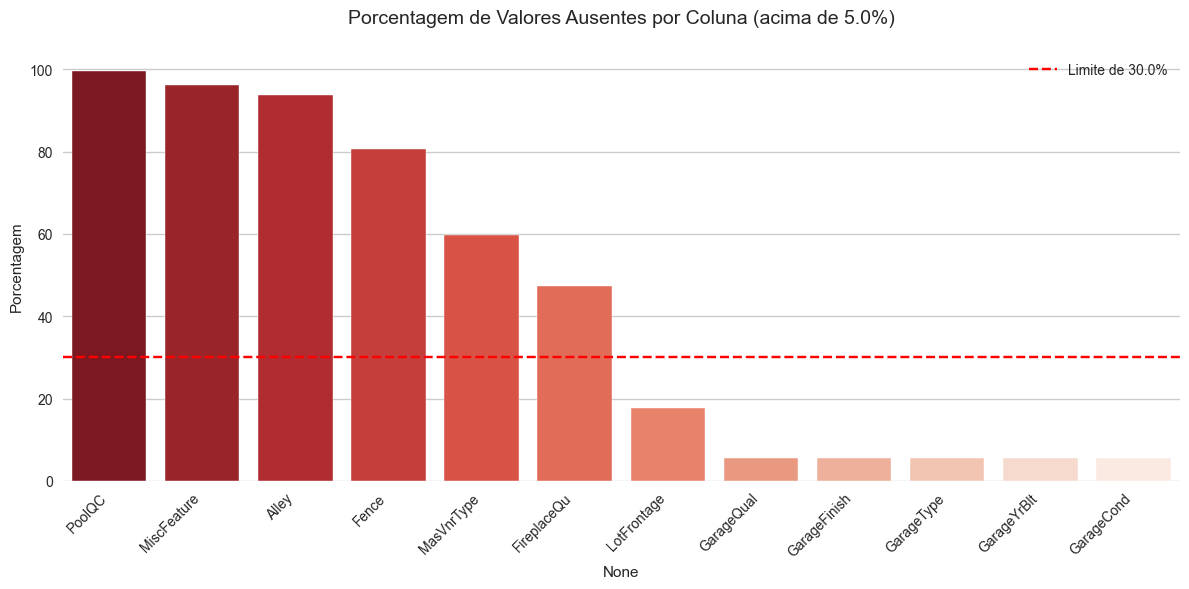




Visualizando distribuição das variáveis numéricas...


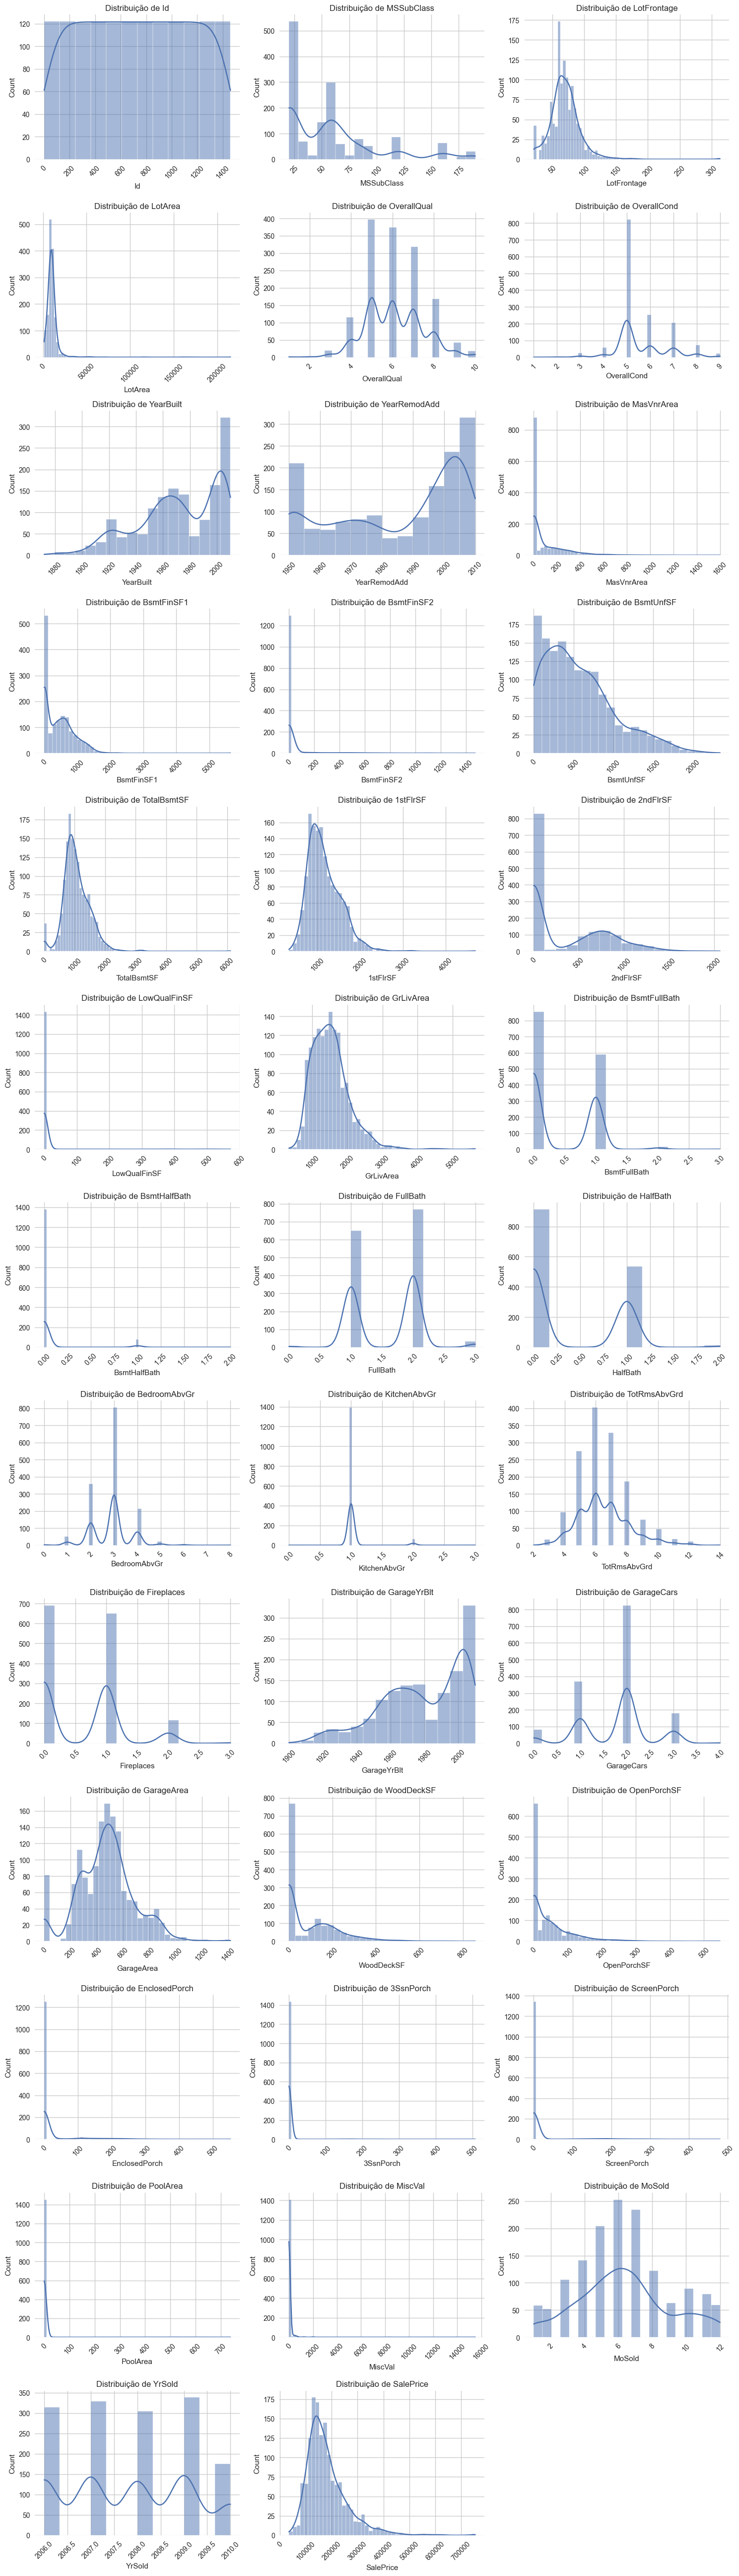


Gerando matriz de correlação...


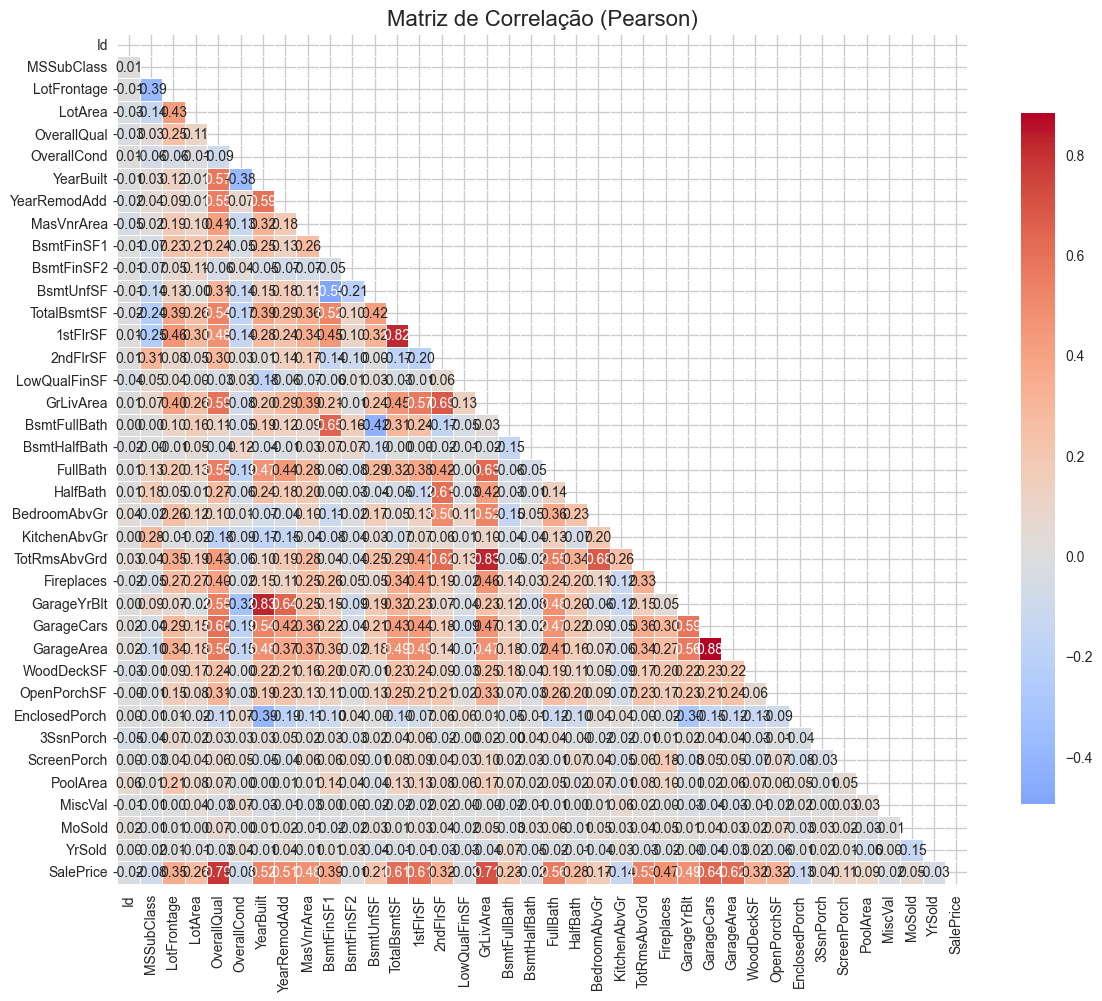

In [5]:
def realizar_analise_exploratoria(train_df):
    """Realiza análise exploratória nos dados de treino."""
    print("\n=== Análise Exploratória de Dados ===")
    
    # Visualizar as primeiras linhas
    print("\nVisualizando as primeiras linhas do conjunto de treino:")
    display(train_df.head())
    
    # Estatísticas descritivas
    print("\nEstatísticas descritivas:")
    display(train_df.describe().T)
    
    # Análise de valores ausentes
    print("\nAnálise de valores ausentes:")
    analisar_valores_ausentes(train_df)
    
    # Visualizar distribuição das variáveis numéricas
    print("\nVisualizando distribuição das variáveis numéricas...")
    numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
    plot_distribuicao_numerica(train_df, numeric_cols)
    
    # Matriz de correlação
    print("\nGerando matriz de correlação...")
    plot_correlacao(train_df)

# Executar análise exploratória
realizar_analise_exploratoria(train_df)

### 4: Pré-processamento dos Dados

In [6]:
def preparar_dados(train_df, test_df, target_column='SalePrice'):
    """Prepara os dados para modelagem."""
    print("\n=== Pré-processamento dos Dados ===")
    
    # Separar features e target
    X = train_df.drop(columns=[target_column])
    y = train_df[target_column]
    
    # Dividir em conjuntos de treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Identificar colunas numéricas e categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    # Criar pré-processador
    preprocessor = create_preprocessor(
        numeric_features=numeric_features,
        categorical_features=categorical_features
    )
    
    return X_train, X_val, y_train, y_val, preprocessor

# Preparar dados
X_train, X_val, y_train, y_val, preprocessor = preparar_dados(train_df, test_df)


=== Pré-processamento dos Dados ===


### 5: Treinamento do Modelo XGBoost

In [ ]:
def treinar_modelo_xgboost(X_train, y_train, preprocessor):
    """Treina um modelo XGBoost com otimização de hiperparâmetros."""
    print("\n=== Treinando Modelo XGBoost ===")
    
    # Criar pipeline
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.01,
        random_state=42,
        n_jobs=-1
    )
    
    # Definir parâmetros para GridSearch
    param_grid = {
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    
    # Criar pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Grid Search
    print("Realizando busca em grade de hiperparâmetros...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Treinar modelo
    grid_search.fit(X_train, y_train)
    
    print(f"\nMelhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor score: {np.sqrt(-grid_search.best_score_)}")
    
    return grid_search.best_estimator_

### 6: Treinamento do Modelo XGBoost

In [10]:
def treinar_modelo_xgboost(X_train, y_train, preprocessor):
    """Treina um modelo XGBoost com otimização de hiperparâmetros."""
    print("\n=== Treinando Modelo XGBoost ===")
    
    # Criar pipeline
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.01,
        random_state=42,
        n_jobs=-1
    )
    
    # Definir parâmetros para GridSearch
    param_grid = {
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    
    # Criar pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Grid Search
    print("Realizando busca em grade de hiperparâmetros...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Treinar modelo
    grid_search.fit(X_train, y_train)
    
    print(f"\nMelhores parâmetros: {grid_search.best_params_}")
    print(f"Melhor score: {np.sqrt(-grid_search.best_score_)}")
    
    return grid_search.best_estimator_

# Treinar modelo
model = treinar_modelo_xgboost(X_train, y_train, preprocessor)


=== Treinando Modelo XGBoost ===
Realizando busca em grade de hiperparâmetros...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Melhores parâmetros: {'model__colsample_bytree': 0.8, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__subsample': 0.8}
Melhor score: 28756.257225167534


### 7: Avaliação do Modelo  


=== Avaliação do Modelo ===

Desempenho no conjunto de treino:

Avaliação do XGBoost (Treino)
MSE: 196158640.0000
RMSE: 14005.6646
MAE: 10089.4844
R²: 0.9671

Desempenho no conjunto de validação:

Avaliação do XGBoost (Validação)
MSE: 643385856.0000
RMSE: 25365.0519
MAE: 16266.4043
R²: 0.9161

Visualizando resíduos...


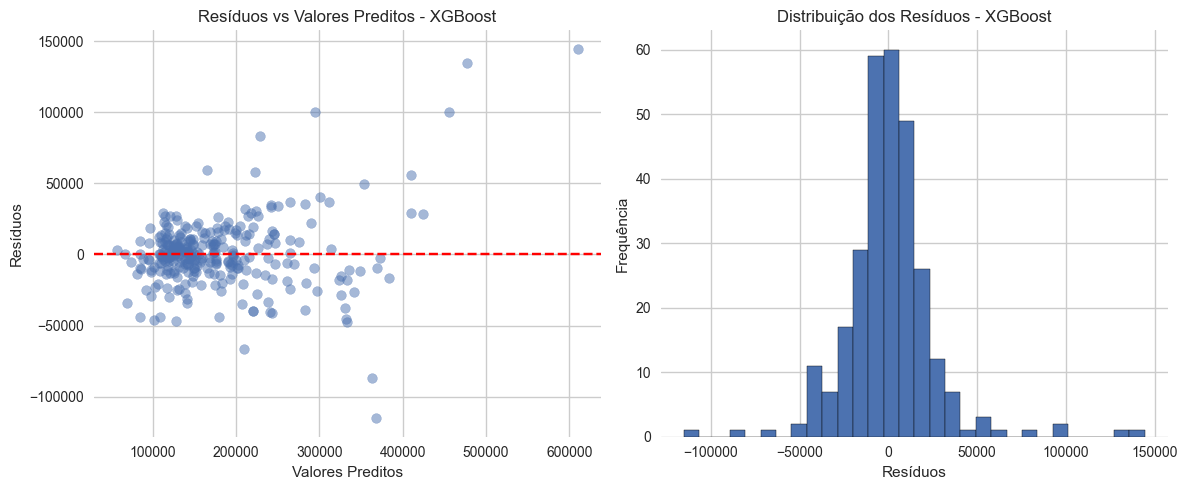

In [11]:
def avaliar_modelo_xgboost(model, X_train, X_val, y_train, y_val):
    """Avalia o desempenho do modelo XGBoost."""
    print("\n=== Avaliação do Modelo ===")
    
    # Fazer previsões
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Avaliar no conjunto de treino
    print("\nDesempenho no conjunto de treino:")
    train_metrics = evaluate_model(y_train, y_train_pred, "XGBoost (Treino)")
    
    # Avaliar no conjunto de validação
    print("\nDesempenho no conjunto de validação:")
    val_metrics = evaluate_model(y_val, y_val_pred, "XGBoost (Validação)")
    
    # Plotar resíduos
    print("\nVisualizando resíduos...")
    plot_residuals(y_val, y_val_pred, "XGBoost")
    
    return train_metrics, val_metrics

# Avaliar modelo
train_metrics, val_metrics = avaliar_modelo_xgboost(model, X_train, X_val, y_train, y_val)

### 8: Feature Importance


=== Importância das Features ===


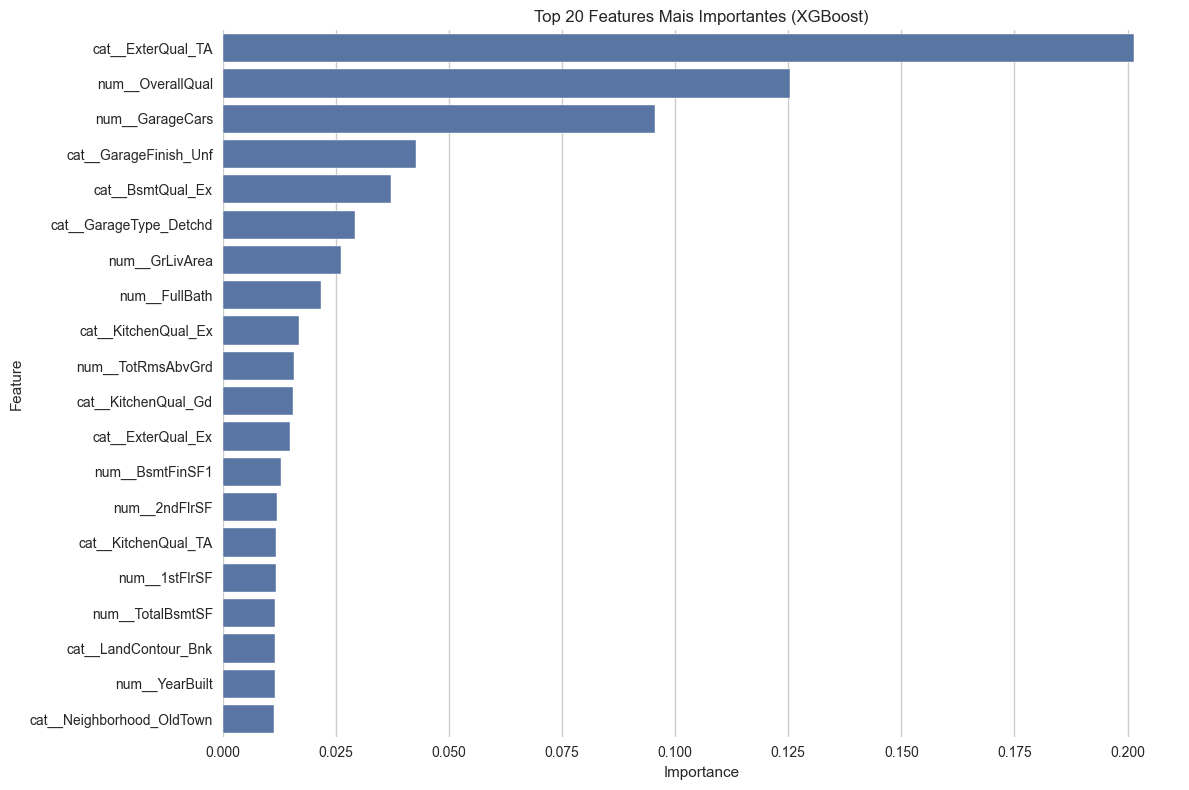

In [12]:
def plot_feature_importance(model, X_train):
    """Plota a importância das features do modelo XGBoost."""
    print("\n=== Importância das Features ===")
    
    # Obter nomes das features após o pré-processamento
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    
    # Obter importância das features
    feature_importance = model.named_steps['model'].feature_importances_
    
    # Criar DataFrame com as importâncias
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Plotar as 20 features mais importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=importance_df.head(20)
    )
    plt.title('Top 20 Features Mais Importantes (XGBoost)')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Plotar importância das features
feature_importance_df = plot_feature_importance(model, X_train)

### 9: Submissão (se aplicável)

In [13]:
def criar_submissao(model, test_df, sample_submission_path, output_path='submission.csv'):
    """Cria arquivo de submissão para competição do Kaggle."""
    print("\n=== Criando Arquivo de Submissão ===")
    
    try:
        # Carregar exemplo de submissão
        sample_submission = pd.read_csv(sample_submission_path)
        
        # Fazer previsões
        test_predictions = model.predict(test_df)
        
        # Criar DataFrame de submissão
        submission = pd.DataFrame({
            'Id': sample_submission['Id'],
            'SalePrice': test_predictions
        })
        
        # Salvar arquivo
        submission.to_csv(output_path, index=False)
        print(f"Arquivo de submissão salvo em: {output_path}")
        
        return submission.head()
        
    except Exception as e:
        print(f"Erro ao criar arquivo de submissão: {e}")
        raise

# Criar submissão (descomente se necessário)
# submission = criar_submissao(
#     model, 
#     test_df,
#     sample_submission_path='../data/raw/sample_submission.csv'
# )
# submission.head()

### 10: Salvando o Modelo

In [14]:
import joblib

def salvar_modelo(model, path='models/xgboost_model.pkl'):
    """Salva o modelo treinado em disco."""
    print(f"\nSalvando modelo em {path}...")
    
    # Criar diretório se não existir
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    
    # Salvar modelo
    joblib.dump(model, path)
    print("Modelo salvo com sucesso!")

# Salvar modelo (descomente se necessário)
# salvar_modelo(model)